### Written by  [Gabriel Borges Pinheiro](github.com/gabrielbopi) & Wissam Melo

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

#### Creating the test environment

In [3]:
def bases(D, x, y, alt=15):
    num_x = int(x/D)
    num_y = int(y/D)
    total = num_x*num_y
    n = np.array([])
    for i in range(num_y):
        for j in range(num_x):
            n = np.append(n, np.array([(j*D)+(D/2),(i*D)+(D/2),alt])) 
        
    return total, n.reshape(total,3)

def usuário(n, x, y):
    UE = np.array([])
    for i in range(n):
        UE = np.append(UE,np.array([x*np.random.random(),y*np.random.random(),1.5]))
    return UE.reshape(n,3)

In [4]:
def BSs_per_UE(BS, UE, total):
    endereços = []

    for n in range(num_ue):
        BS_UE = np.array([])
        conectadas = 0
        for i in range(total):
            dist = np.linalg.norm(BS[i]-UE[n])
            if dist <= 50:
                conectadas += 1
                BS_UE = np.append(BS_UE, BS[i])
        BS_UE = np.append(BS_UE, 0)
        endereços = np.append(endereços,BS_UE)
  
    # using list comprehension + zip() + slicing + enumerate() 
    # Split list into lists by particular value 
    size = len(endereços) 
    idx_list = [idx + 1 for idx, val in enumerate(endereços) if val == 0] 
    res = [endereços[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))]
    
    for i in range(len(res)):
        indices = np.where(res[i]==0)
        res[i] = np.delete(res[i], indices)
        res[i] = res[i].reshape(int((res[i].shape[0])/3),3)
    res = np.array(res)
    return res

In [5]:
def UEs_per_BS(BS, UE, total):
    positions = []

    for n in range(total):
        BS_UE = np.array([])
        conectados = 0
        for i in range(len(UE)):
            dist = np.linalg.norm(BS[n]-UE[i])
            if dist <= 50:
                conectados += 1
                BS_UE = np.append(BS_UE, UE[i])
        BS_UE = np.append(BS_UE, 0)
        positions = np.append(positions,BS_UE)
    
    # using list comprehension + zip() + slicing + enumerate() 
    # Split list into lists by particular value 
    size = len(positions) 
    idx_list = [idx + 1 for idx, val in enumerate(positions) if val == 0]
    antenna = [positions[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))] 

    for i in range(len(antenna)):
        indices = np.where(antenna[i]==0)
        antenna[i] = np.delete(antenna[i], indices)
        antenna[i] = antenna[i].reshape(int((antenna[i].shape[0])/3),3)
    return antenna

##### Generating BSs and UEs

In [6]:
#Espaçamento entre cada BS
gap_bs = 50 #m
#Number of users
num_ue = 1

total,BS = bases(gap_bs, 200, 100)
UE = usuário(num_ue, 200, 100)
UEs_antenna = UEs_per_BS(BS, UE, total)
BSUE = BSs_per_UE(BS, UE, total)

In [7]:
BS

array([[ 25.,  25.,  15.],
       [ 75.,  25.,  15.],
       [125.,  25.,  15.],
       [175.,  25.,  15.],
       [ 25.,  75.,  15.],
       [ 75.,  75.,  15.],
       [125.,  75.,  15.],
       [175.,  75.,  15.]])

In [8]:
UE

array([[86.53865072, 98.68901145,  1.5       ]])

In [9]:
UEs_antenna

[array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([[86.53865072, 98.68901145,  1.5       ]]),
 array([[86.53865072, 98.68901145,  1.5       ]]),
 array([], shape=(0, 3), dtype=float64)]

In [10]:
UEs_antenna[2].shape[0]

0

In [11]:
BSUE

array([[[ 75.,  75.,  15.],
        [125.,  75.,  15.]]])

#### Calculating the parameters

In [12]:
def db(X):
    return 10 * np.log10(np.abs(X))
def inv_db(X):
    return 10**(X/10)
def dbm(X):
    return 10 * np.log10(np.abs(X)/(1e-3))
def inv_dbm(X):
    return (1e-3) * 10**(X/10)

In [13]:
def β_channel(D):
    """
    Returns the 
    """
    #Carrier frequency (LTE band 7)
    f = 2.6e9
    #Wavelength
    λ = 3e8/f
    R = D
    #Linear pathloss
    L_lin =  (λ/(4*np.pi*R))**2
    β = L_lin
    return β

def rand_channel(D, N):
    """
    Returns the channel
    """
    β = β_channel(D)
    ampl = np.sqrt(β)/2
    h = (np.random.randn(N) + 1j*np.random.randn(N)) * ampl
    return h

def channel_user2(num_ue,numBS,nAntennas,UEpos,BSpos,UEs_antenna):
    """
    Retorna uma matriz 3D, onde h[UE][BS]{stream}
    """
    H = np.zeros((num_ue,numBS,nAntennas),dtype=complex)

    for ii in range(numBS):
        for jj in range(UEs_antenna[ii].shape[0]):
            user = np.argmin(np.sum(np.abs(UEs_antenna[ii][jj] - UEpos),axis=1))
            R = np.linalg.norm(BSpos[ii] - UEs_antenna[ii][jj]) 
            H[int(user)][ii] = rand_channel(R, nAntennas)

    return H

def powerUE(num_ue, total, UEpos,UEs_antenna, P_dBm):
    p = np.zeros(num_ue)
    for i in range(total):
        UE_BS = UEs_antenna[i].shape[0]
        for j in range(UEs_antenna[i].shape[0]):
            user = np.argmin(np.sum(np.abs(UEs_antenna[i][j] - UEpos),axis=1))
            p[int(user)] =  p[int(user)] + (inv_dbm(P_dBm)/int(UE_BS))
    return dbm(p)

def get_beamforming(h, num_ue, total, P_dBm):
    p = inv_dbm(P_dBm)
    v = np.zeros((num_ue,total*N), dtype = 'complex_')
    for i in range(num_ue):
        v[i] = np.sqrt(p[i])*(np.conjugate(h[i])/np.linalg.norm(h[i]))
        
    return v

In [14]:
P_dBm = 40
P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
P_dBm

array([43.01029996])

In [15]:
#Numero de antenas no arranjo
N = 5

#h = channel_user(N, UE, total, BSUE)
H = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)

In [16]:
H

array([[[ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.000

In [17]:
BSUE[0].shape[0]

2

In [18]:
def vectorize(H, num_ue, total, N):
    h = np.zeros((num_ue, N*total), dtype ='complex_')
    for i in range(num_ue):
        h[i] = H[i].reshape(N*total)
    return h

H = vectorize(H, 1, total, N)

In [19]:
H

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, -1.73938272e-04-5.37168415e-05j,
        -8.16698383e-05+1.72885649e-04

In [20]:
v = get_beamforming(H, num_ue, total, P_dBm)

In [21]:
v

array([[ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , -1.33849143+0.41336235j,
        -0.62846651-1.33039128j,  2.08578431-0.80428658j,
         1.31375375-1.26645893j, -0.883953  -0.95339598j,
         0.79545377+0.38803092j, -0.94759585+0.10393494j,
         0.18639171-1.22648539j, -1.28342291+0.40177396j,
         0.254

In [22]:
#Band of signal
B = 1e6 #Hz
#Power of noise (-127dBm is average)
N0 = inv_dbm(-127)
σ = B*N0

In [23]:
σ

1.9952623149688826e-10

In [24]:
def sinr(h, V, j, σ):
    
    num = np.abs(V[j].transpose()@h)**2
    den = np.zeros(num.shape)
    for x in range(V.shape[0]):
        #if V[x]:
        if x!=j:
            #den = np.add(den, np.abs(V[x].transpose()@h)**2)
            den += np.abs(V[x].transpose()@h)**2
    return (num/(den+σ))

In [25]:
j = 0
s_inr = sinr(H[j], v, j, σ)

In [26]:
s_inr

33854.71031080526

In [27]:
print(db(s_inr))

45.29619101962804


In [28]:
S = np.zeros(len(UE))
for i in range(len(UE)):
    S[i] = sinr(H[i], v, i, σ)


In [29]:
print(np.sum(np.log2(S+1)))
#C

15.047111567627002


In [30]:
BS.shape[0]

8

In [41]:
def sinr_mc(num_ue, N, BS, P_dBm):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(num_ue, 200, 100)
    UEs_antenna = UEs_per_BS(BS, UE, total)
    P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
    H = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)
    H = vectorize(H, num_ue, total, N)
    V = get_beamforming(H, num_ue, total, P_dBm)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1))
    
    return C

[0.03148992 0.03175131 0.0324143  0.0362085  0.0366661  0.03858013
 0.03863746 0.04034013 0.04049054 0.04125169 0.04147251 0.04197214
 0.04225373 0.04278549 0.04293012 0.04360541 0.04374903 0.04383175
 0.04442644 0.04457781 0.04570599 0.04573388 0.04596081 0.04625121
 0.0474286  0.04779587 0.0479401  0.04885673 0.04890692 0.04979932
 0.04988315 0.04989944 0.05046109 0.05051721 0.05213282 0.05214298
 0.05222505 0.05246538 0.05314081 0.05364516 0.05391067 0.05414499
 0.05444996 0.05451109 0.05466054 0.05493009 0.05521931 0.055548
 0.05561645 0.05621139 0.056327   0.05638932 0.05726498 0.05756165
 0.05762821 0.05763473 0.05777107 0.05793549 0.05809056 0.05815559
 0.05821816 0.05853278 0.05862399 0.05886577 0.05905321 0.0591458
 0.05930098 0.06001029 0.06077241 0.06140663 0.06158295 0.06168785
 0.0620092  0.06207208 0.06278113 0.06329597 0.0633584  0.06355697
 0.06358226 0.06441926 0.06479837 0.064942   0.06502679 0.06535014
 0.06593954 0.0660143  0.06610151 0.06614505 0.0666563  0.0666951

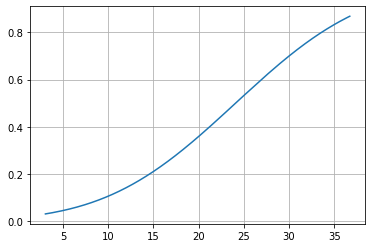

In [143]:
mc = 1000
C = np.zeros(mc)
for j in range(mc):
    np.random.seed(j)
    C[j] = sinr_mc(2, N, BS, P_dBm)
CDF = norm.cdf(np.sort(C),loc=np.mean(C),scale=np.std(C))
print(CDF)
print(C.shape)
print(np.std(C))
label = ('{} users'.format(2))
plt.plot(np.sort(C), CDF, label=label)
plt.grid()

In [42]:
print(sinr_mc(1, N, BS, 40))

13.520479831720168


In [150]:
n = [1,2,4,6,8,10,12,14,16,18,19,20,22,24,26,28,30,32,34,36,38,40]
us = [1,2,8,16,24,32,40,45,50,55,60]

In [101]:
type(n[i])

int

In [125]:
def cdf(C):
    C = np.sort(C)
    average_C = np.mean(C)
    std_C = np.std(C)
    cdf_C = norm.cdf(C, loc=average_C, scale=std_C)
    return cdf_C, average_C

n - 1
n - 2
n - 8
n - 16
n - 24
n - 32
n - 40


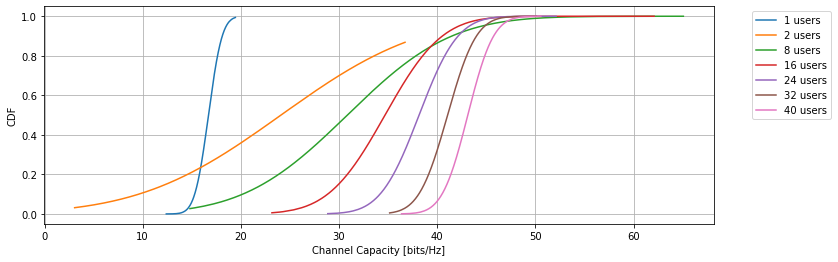

In [131]:
plt.figure(figsize=(12,4))
AVG = np.array([])
for i in range(len(us)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sinr_mc(us[i], N, BS, P_dBm)
        AVG = np.append(AVG, avg)
    CDF, avg = cdf(C)
    label = ('{} users'.format(us[i]))
    plt.plot(np.sort(C), CDF, label=label)
    print("n - " + str(us[i]))
plt.ylabel("CDF")
plt.xlabel("Channel Capacity [bits/Hz]")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

n - 1
n - 2
n - 4
n - 6
n - 8
n - 10
n - 12
n - 14
n - 16
n - 18
n - 19
n - 20
n - 22
n - 24
n - 26
n - 28
n - 30
n - 32
n - 34
n - 36
n - 38
n - 40


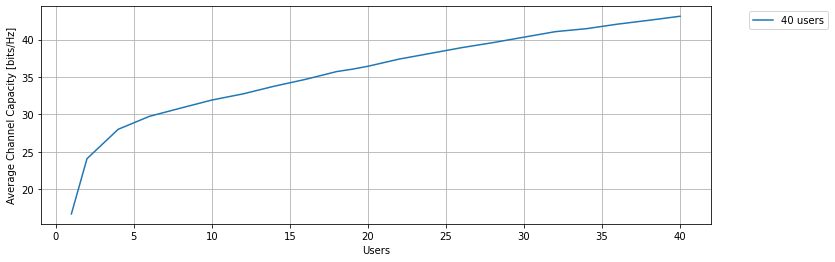

In [151]:
plt.figure(figsize=(12,4))
AVG = np.array([])
for i in range(len(n)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sinr_mc(n[i], N, BS, P_dBm)
    CDF, avg = cdf(C)
    AVG = np.append(AVG, avg)
    label = ('{} users'.format(n[i]))
    print("n - " + str(n[i]))
plt.plot(n, AVG, label=label)
plt.ylabel("Average Channel Capacity [bits/Hz]")
plt.xlabel("Users")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

In [37]:
def cdf(C):
    C = np.sort(C)
    average_C = np.mean(C)
    std_C = np.std(C)
    cdf_C = norm.cdf(C, loc=average_C, scale=std_C)
    return cdf_C

In [ ]:
for i in n:
    C = np.sort(C)# / num_ue
    average_C = np.mean(C)
    std_C = np.std(C)
    cdf_C = norm.cdf(C, loc=average_C, scale=std_C)
    
    label = ('{} users'.format(i))
    ax.plot(C, cdf_C, label=label)
    print('Average Channel Capacity for {} users: {} bits/Hz'.format(i, average_C))
ax.set_ylabel("CDF")
ax.set_xlabel("Channel Capacity [bits/Hz]")
plt.legend()

##### Main parameters

In [78]:
#Numero de antenas no arranjo
N = 5

#Tamanho das torres de BS
bs_height = 15 #m
#Espaçamento entre cada BS
gap_bs = 50 #m

#Potencia de cada base
P_t = 40 #dBm

#Number of Monte Carlo realizations
mc = 1000

#### Plotting a map

IndexError: index 2 is out of bounds for axis 0 with size 1

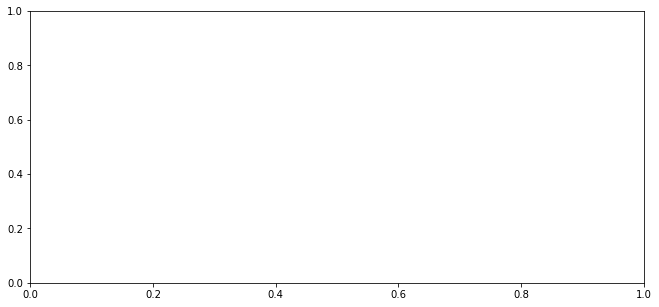

In [84]:
#total,BS = bases(50, 200, 100)
#número de UEs
max_UE = 4
N_ue = np.arange(max_UE)+1

#Calculando a capacidade de canal para UE recebendo sinal de todas as BS:
p = np.ones(max_UE)
p = p * inv_dbm(P_t)

fig, ax = plt.subplots(figsize = (11,5))
for num_ue in N_ue:
    C = np.zeros(mc)
    for k in range(mc):
        UE = usuário(num_ue, 200, 100)
        h = channel_user(N, UE, res, i)
        w = get_beamforming(h)
        SINR = sinr(h, w, j, i, σ)
        for SINRi in SINR:
            C[k] += np.log2(1+SINRi.mean())
    C = np.sort(C)# / num_ue
    average_C = np.mean(C)
    std_C = np.std(C)
    cdf_C = norm.cdf(C, loc=average_C, scale=std_C)
    
    label = ('{} users'.format(num_ue))
    ax.plot(C, cdf_C, label=label)
    print('Average Channel Capacity for {} users: {} bits/Hz'.format(num_ue, average_C))
ax.set_ylabel("CDF")
ax.set_xlabel("Channel Capacity [bits/Hz]")
plt.legend()

In [10]:
n_ue = 4
p = np.ones(n_ue)
p = p * inv_db(P_t)
UE = usuário(n_ue, 200, 100)
SINR = compute_sinr(N, UE, BS, p, n_stream)
print('SINR: {}'.format(SINR))
SINR_mean = SINR[0].mean()
print('SINRmean: {}'.format(SINR_mean))

SINR: [[0.53878442 1.30153095 0.62102836]
 [0.62546247 0.72921625 1.00310427]
 [0.68964899 1.04231687 0.69224802]
 [0.7052931  0.70038512 0.51387591]]
SINRmean: 0.820447907679085
